Problem Statement: 
Face Spoofing detection


Import Neccessary libraries

In [254]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import keras

import cv2
import os

# Importing the Keras libraries from tensorflow and its packages

from keras.layers import Dense, Flatten, Conv2D, Dropout, Activation
from keras.models import Sequential
from keras.layers import MaxPooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import random

In [200]:
# Get the current directory
os.getcwd()

'E:\\AIR CENTER\\dataset'

Split the training and test folders with its image using split-folders library

In [202]:
# pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [203]:
os.chdir('E:\AIR CENTER\dataset')
os.getcwd()

'E:\\AIR CENTER\\dataset'

In [204]:
# Size of the training and the testing images

train_size = sum([len(files) for dirname, _, files in os.walk('Splitting_Folders/train')])
test_size = sum([len(files) for dirname, _, files in os.walk('Splitting_Folders/test')])
print(f'Number of training images: {train_size} \nNumber of test images: {test_size}')

Number of training images: 1632 
Number of test images: 409


Define all the contraints

In [233]:
BATCH_SIZE = 128
EPOCHS = 10
IMG_HEIGHT = 128
IMG_WIDTH = 128
OPTIMIZERS = ['adam'] #['adam', 'rmsprop', 'SGD']
LOSS_FUNCTIONS = ['binary_crossentropy']  #['sparse_categorical_crossentropy', 'kullback_leibler_divergence']  


Image generator for the input features

Function to convert the original image into HSV+YCrCb format

In [332]:
def images_gen(img_name, colorspace):
    if colorspace == 'hsv':
        train_img = cv2.cvtColor(img_name, cv2.COLOR_BGR2HSV)
        train_img[0, :, :] = train_img[0, :, :]/180.
        train_img[1:3, :, :] = train_img[1:3, :, :]/255.
    if colorspace == 'ycrcb':
        train_img = cv2.cvtColor(img_name, cv2.COLOR_BGR2YCrCb)

    if colorspace != 'hsv':
        train_img = train_img/255.      
    return train_img 

Original faces

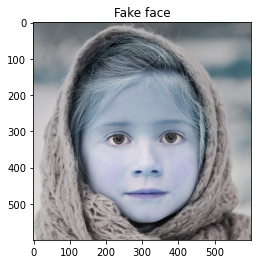

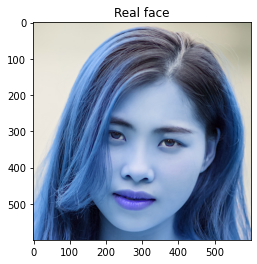

In [235]:
img_fake = cv2.imread("E:\\AIR CENTER\\dataset\\Splitting_Folders\\test\\data_fake\\hard_93_1111.jpg")
plt.imshow(img_fake)
plt.title('Fake face')
plt.show()

img_real = cv2.imread('E:\\AIR CENTER\\dataset\\Splitting_Folders\\test\\data_real\\real_00981.jpg')
plt.imshow(img_real)
plt.title('Real face')
plt.show()

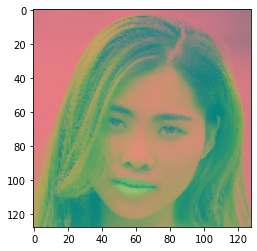

In [330]:
im2 = images_gen('E:\\AIR CENTER\\dataset\\Splitting_Folders\\test\\data_real\\real_00981.jpg','ycrcb')
plt.imshow(im2)
plt.show()

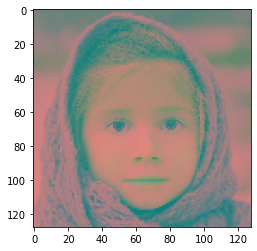

In [331]:
im=images_gen('E:\\AIR CENTER\\dataset\\Splitting_Folders\\test\\data_fake\\hard_93_1111.jpg','ycrcb')
plt.imshow(im)
plt.show()

In [336]:
def get_images(path, img_shape=(64, 64)):
    #Returns a np array of images and labels from path
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
 
        label = idx
        
        sub_list = sorted(os.listdir(os.path.join(main_path,folder)))
 
        for i in tqdm(range(1, len(sub_list))):
            image_path = os.path.join(main_path, folder, sub_list[i])
            read_image = cv2.imread(image_path)
            image_resized =  cv2.resize(read_image, (128, 128))
            image_resized = images_gen(image_resized, 'ycrcb')
 
            image = np.float32(image_resized)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Change alpha, beta according to the preprocessing you desire
            
            image_collection.append(image)
            
            y.append(label)
 
    y = np.array(y)
    y = keras.utils.np_utils.to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 

In [337]:
# Preparing test and trainng datasets

TRAIN_DIR = 'Splitting_Folders/train'
TEST_DIR = 'Splitting_Folders/test'
X_train,y_train = get_images(TRAIN_DIR)
X_test,y_test = get_images(TEST_DIR)
X_train = np.array(X_train)
X_test = np.array(X_test)

  1%|          | 4/767 [00:00<00:23, 31.83it/s]

['data_fake', 'data_real']


  2%|▏         | 3/191 [00:00<00:06, 29.49it/s]

['data_fake', 'data_real']


100%|██████████| 216/216 [00:08<00:00, 26.10it/s]


In [338]:
print('Training set', X_train.shape)
print('Test set', X_test.shape)

Training set (1630, 128, 128, 3)
Test set (407, 128, 128, 3)


Creating the CNN model layers.

In [378]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu',input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=64, activation='relu', kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=32, activation='relu', kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32, activation='relu', kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=32, activation='relu', kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Dropout to avoid overfitting
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2))
    # Compiling the model
    model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

    return model

In [379]:
model = create_model()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 63, 63, 128)       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 30, 30, 64)      

In [380]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
51/51 [==============================] - 107s 2s/step - loss: 1.3440 - accuracy: 0.4902 - val_loss: 1.2910 - val_accuracy: 0.4693
Epoch 2/10
51/51 [==============================] - 105s 2s/step - loss: 0.7322 - accuracy: 0.4933 - val_loss: 1.2030 - val_accuracy: 0.4693
Epoch 3/10
51/51 [==============================] - 104s 2s/step - loss: 0.7209 - accuracy: 0.4883 - val_loss: 1.0697 - val_accuracy: 0.4693
Epoch 4/10
51/51 [==============================] - 109s 2s/step - loss: 0.7206 - accuracy: 0.4834 - val_loss: 1.0376 - val_accuracy: 0.4693
Epoch 5/10
51/51 [==============================] - 129s 3s/step - loss: 0.7068 - accuracy: 0.4975 - val_loss: 1.0112 - val_accuracy: 0.4693
Epoch 6/10
51/51 [==============================] - 102s 2s/step - loss: 0.7050 - accuracy: 0.4853 - val_loss: 0.9236 - val_accuracy: 0.5160
Epoch 7/10
51/51 [==============================] - 91s 2s/step - loss: 0.7056 - accuracy: 0.4840 - val_loss: 0.8756 - val_accuracy: 0.5233
Epoch 8/10
51/

Model Evaluation

In [430]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Function to plot confusion matrix
def confusion(title, matrix):
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(matrix, annot=True, cmap='ocean_r', )
    # labels, title and ticks
    labels = ['Fake', 'Real']
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.xticks([0.5, 1.5], labels=labels)
    plt.yticks([0.5, 1.5], labels=labels)
    plt.show()

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [431]:
def classifer(list):
    emp = []
    for i in range(len(list)):
        if list[i].max() < 0.12 :
            emp.append(0.0)
        else:
            emp.append(1.0)
    return emp
train_pred = classifer(train_pred)
test_pred = classifer(test_pred)

# Report for the test dataset
print(classification_report(y_train, train_pred))
print('/n')
# Report for the test dataset
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       863
         1.0       0.47      1.00      0.64       767

    accuracy                           0.47      1630
   macro avg       0.24      0.50      0.32      1630
weighted avg       0.22      0.47      0.30      1630

/n
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       216
         1.0       0.47      1.00      0.64       191

    accuracy                           0.47       407
   macro avg       0.23      0.50      0.32       407
weighted avg       0.22      0.47      0.30       407

